# Step 3

## Use the projection to gradient space to predict task condition

Here we take the reconstructed time series, average within each condition and try to predict the condition in new subjects.

In [63]:
%matplotlib inline

import numpy as np
import h5py as h5

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon, ttest_rel

from fgrad.predict import features_targets

In [2]:
#f = h5.File('../data/reconstructed_WM.hdf5')
#d_LR = f['Working_memory/LR']
#d_RL = f['Working_memory/RL']

In [2]:
f = h5.File('/Users/marcel/projects/HCP/volumes_embedded_full.hdf5')
d_LR = f['Working_memory/Run1']
d_RL = f['Working_memory/Run2']

## Within-run averaging

We take the time points corresponding to each task condition and average them independently within each run.

In [3]:
labels = dict()
labels['WM_fix'] = 0
labels['WM_0back'] = 1
labels['WM_2back'] = 2

In [4]:
# Block onsets expressed as TRs
# We add 6 volumes (4.32 s) to each onset to take into account hemodynamic lag 
# and additional 4 volumes (2.88 s) to account for instruction
nback_LR_2b = np.round(np.array([7.977, 79.369, 150.553, 178.689])/0.72).astype(int)+10
nback_LR_0b = np.round(np.array([36.159, 107.464, 221.965, 250.18])/0.72).astype(int)+10
nback_RL_2b = np.round(np.array([7.977, 79.369, 178.769, 250.22])/0.72).astype(int)+10
nback_RL_0b = np.round(np.array([36.159, 107.464, 150.567, 222.031])/0.72).astype(int)+10
nback_fix = np.array([88, 187, 286])+6

# Each block lasts for 27.5 seconds
vols_2b_LR = np.concatenate([range(x,x+38) for x in nback_LR_2b])
vols_0b_LR = np.concatenate([range(x,x+38) for x in nback_LR_0b])
vols_2b_RL = np.concatenate([range(x,x+38) for x in nback_RL_2b])
vols_0b_RL = np.concatenate([range(x,x+38) for x in nback_RL_0b])
vols_fix = np.concatenate([range(x,x+22) for x in nback_fix])
vols_fix = np.concatenate([vols_fix, range(395, 405)])

# Targets
nback_targets_LR = np.zeros(405)
nback_targets_LR[vols_2b_LR] = 1
nback_targets_LR[vols_fix] = -1

nback_targets_RL = np.zeros(405)
nback_targets_RL[vols_2b_RL] = 1
nback_targets_RL[vols_fix] = -1

In [5]:
# Get random group assignments
subjects = f['Working_memory/Subjects'][...]
np.random.seed(123)
sind = np.arange(len(subjects))
G1 = sorted(np.random.choice(sind, 100, replace = False ))
sind = np.delete(sind,G1)
G2 = sorted(np.random.choice(sind, 100, replace = False ))
sind = np.delete(sind,G2)
G3 = sorted(np.random.choice(sind, 100, replace = False ))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


## Prepare the features

In [6]:
conds = ['WM_fix', 'WM_0back', 'WM_2back']
grads = [0,1,2]

# Group 1

f_WM_train1, t_WM_train1 = features_targets(data = d_LR, subjects = G1, 
                                      inds = nback_targets_LR, condnames = conds, gradients = grads, labels = labels)

f_WM_train2, t_WM_train2 = features_targets(data = d_RL, subjects = G1, 
                                      inds = nback_targets_RL, condnames = conds, gradients = grads, labels = labels)

# Group 2

f_WM_train3, t_WM_train3 = features_targets(data = d_LR, subjects = G2, 
                                      inds = nback_targets_LR, condnames = conds, gradients = grads, labels = labels)

f_WM_train4, t_WM_train4 = features_targets(data = d_RL, subjects = G2, 
                                      inds = nback_targets_RL, condnames = conds, gradients = grads, labels = labels)

# Group 3

f_WM_test1, t_WM_test1 = features_targets(data = d_LR, subjects = G3, 
                                      inds = nback_targets_LR, condnames = conds, gradients = grads, labels = labels)

f_WM_test2, t_WM_test2 = features_targets(data = d_RL, subjects = G3, 
                                      inds = nback_targets_RL, condnames = conds, gradients = grads, labels = labels)

# Classify the task conditions

#### Assemble the training and test sets

In [7]:
f_WM_train = np.vstack([f_WM_train1, f_WM_train2, f_WM_train3, f_WM_train4])
t_WM_train = np.concatenate([t_WM_train1, t_WM_train2, t_WM_train3, t_WM_train4])

f_WM_test = np.vstack([f_WM_test1, f_WM_test2])
t_WM_test = np.concatenate([t_WM_test1, t_WM_test2])

#### Cross-validate to get optimal parameters

In [8]:
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

groups = np.concatenate([np.ones(600),np.ones(600)+1])

p_grid = {"linearsvc__C": np.linspace(0.01,1.01,100)}
svc = LinearSVC(C=0.25, penalty="l1", dual=False)
scl = StandardScaler()
svc_z = make_pipeline(scl, svc)

gss = GroupShuffleSplit(n_splits=100, train_size=0.5, random_state=0)
gscv = GridSearchCV(svc_z, param_grid=p_grid, cv=gss, n_jobs = 1)

gscv.fit(f_WM_train, t_WM_train, groups = groups)

GridSearchCV(cv=GroupShuffleSplit(n_splits=100, random_state=0, test_size=0.2, train_size=0.5),
       error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=0.25, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'linearsvc__C': array([ 0.01  ,  0.0201, ...,  0.9999,  1.01  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [9]:
gscv.best_params_

{'linearsvc__C': 0.16151515151515153}

In [10]:
svc = LinearSVC(C=gscv.best_params_['linearsvc__C'], penalty="l1", dual=False)
svc.fit(f_WM_train, t_WM_train)
print svc.coef_

[[  0.         -21.58886598   0.        ]
 [-14.69845853   9.72156734 -18.50369948]
 [  0.           5.5189651   31.5671286 ]]


### Examine the performance on independent data

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print "Training accuracy: %.2f" % svc.score(f_WM_train, t_WM_train)
print "Test accuracy: %.2f" % svc.score(f_WM_test, t_WM_test)
print "Confusion matrix:\n\n", confusion_matrix(t_WM_test, gscv.best_estimator_.predict(f_WM_test))
print "\n\nClassification report (train):\n\n", classification_report(t_WM_train, gscv.best_estimator_.predict(f_WM_train))
print "\n\nClassification report (test):\n\n", classification_report(t_WM_test, gscv.best_estimator_.predict(f_WM_test))

Training accuracy: 0.95
Test accuracy: 0.94
Confusion matrix:

[[197   3   0]
 [  2 181  17]
 [  0  12 188]]


Classification report (train):

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       400
          1       0.93      0.92      0.93       400
          2       0.93      0.94      0.93       400

avg / total       0.95      0.95      0.95      1200



Classification report (test):

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       200
          1       0.92      0.91      0.91       200
          2       0.92      0.94      0.93       200

avg / total       0.94      0.94      0.94       600



## Pairwise comparisons between values on each gradient

In [110]:
print "G     fix             0-back          2-back          0b-fix              2b-fix              2b-0b"
print "==============================================================================================================="
for g in range(3):
    val = []
    val.append(g)
    val.append(np.mean(f_WM_test[range(0,200,3),g]))
    val.append(np.std(f_WM_test[range(0,200,3),g]))
    val.append(np.mean(f_WM_test[range(1,200,3),g]))
    val.append(np.std(f_WM_test[range(1,200,3),g]))
    val.append(np.mean(f_WM_test[range(2,201,3),g]))
    val.append(np.std(f_WM_test[range(2,201,3),g]))
    val.append(ttest_rel(f_WM_test[range(1,200,3),g], f_WM_test[range(0,200,3),g]))
    val.append(ttest_rel(f_WM_test[range(2,201,3),g], f_WM_test[range(0,200,3),g]))
    val.append(ttest_rel(f_WM_test[range(2,201,3),g], f_WM_test[range(1,200,3),g]))
    
    print "%d %9.3f (%.3f)  %6.3f (%.3f)  %6.3f (%.3f)  %6.2f (p = %.3f)  %6.2f (p = %.3f)  %6.2f (p = %.3f)" % (val[0], val[1], val[2], val[3], val[4], val[5], val[6],
                                                                     val[7][0], val[7][1], val[8][0], val[8][1],
                                                                                         val[9][0], val[9][1])

G     fix             0-back          2-back          0b-fix              2b-fix              2b-0b
0     0.017 (0.019)  -0.014 (0.010)   0.008 (0.012)  -10.20 (p = 0.000)   -2.72 (p = 0.008)    9.18 (p = 0.000)
1    -0.082 (0.031)   0.009 (0.008)   0.032 (0.014)   20.83 (p = 0.000)   21.40 (p = 0.000)   10.67 (p = 0.000)
2    -0.026 (0.018)  -0.010 (0.008)   0.026 (0.013)    6.01 (p = 0.000)   14.54 (p = 0.000)   14.64 (p = 0.000)


## Plot the conditions in gradient-space

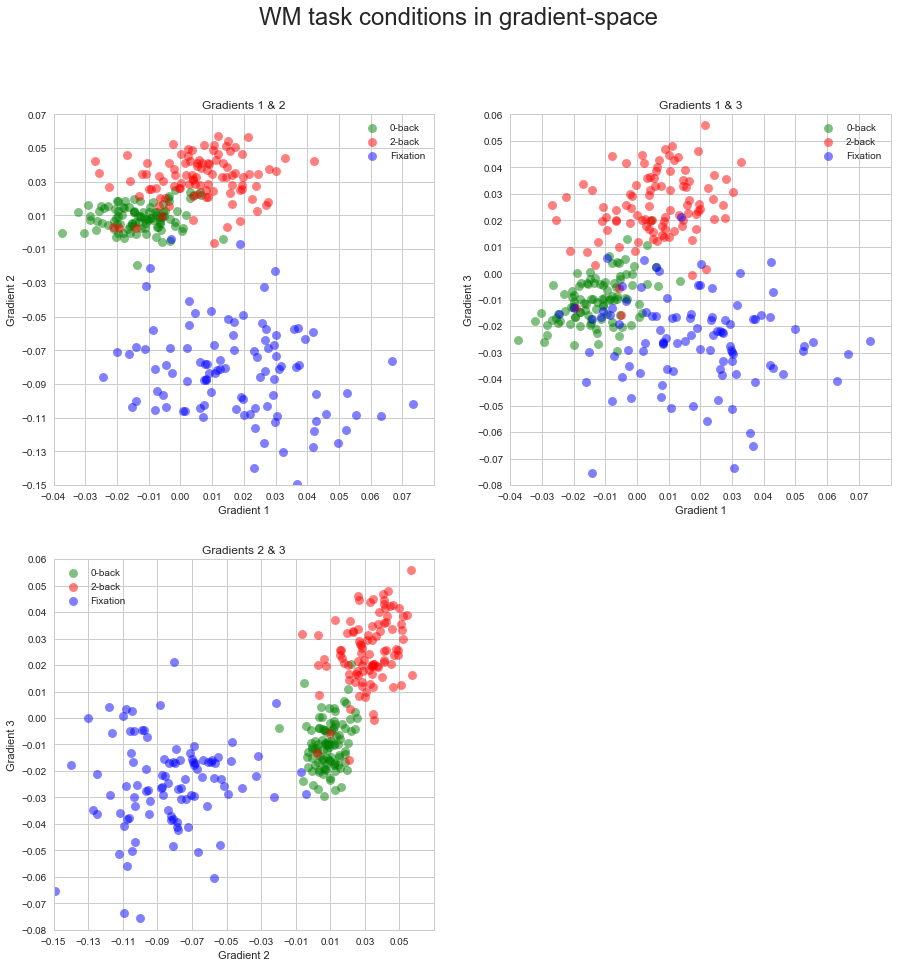

In [23]:
X1=f_WM_test1[range(1,300,3),0]
Y1=f_WM_test1[range(1,300,3),1]
Z1=f_WM_test1[range(1,300,3),2]

X2=f_WM_test1[range(2,301,3),0]
Y2=f_WM_test1[range(2,301,3),1]
Z2=f_WM_test1[range(2,301,3),2]

X3=f_WM_test1[range(0,300,3),0]
Y3=f_WM_test1[range(0,300,3),1]
Z3=f_WM_test1[range(0,300,3),2]

sns.set_style('whitegrid')

m = 'o'
l = 0
s = 80
a = 0.5

fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(221)
ax.set_title('Gradients 1 & 2')

ax.scatter(X1, 
           Y1, 
           c = 'green', label = "0-back", marker = m, lw = l, s = s, alpha = a)

ax.scatter(X2, 
           Y2, 
           c = 'red', label = "2-back", marker = m, lw = l, s = s, alpha = a)

ax.scatter(X3, 
           Y3, 
           c = 'blue', label = "Fixation", marker = m, lw = l, s = s, alpha = a)

ax.legend(loc = "upper right")

ax.set_xlabel("Gradient 1")
ax.set_ylabel("Gradient 2")
ax.set_xlim((-0.04,0.08))
ax.set_ylim((-0.15,0.07))

ax.set_yticks(np.arange(-0.15,0.08,0.02))
ax.set_xticks(np.arange(-0.04,0.07,0.01))

ax = fig.add_subplot(222)
ax.set_title('Gradients 1 & 3')

ax.scatter(X1, 
           Z1, 
           c = 'green', label = "0-back", marker = m, lw = l, s = s, alpha = a)

ax.scatter(X2, 
           Z2, 
           c = 'red', label = "2-back", marker = m, lw = l, s = s, alpha = a)

ax.scatter(X3, 
           Z3, 
           c = 'blue', label = "Fixation", marker = m, lw = l, s = s, alpha = a)

ax.legend(loc = "upper right")

ax.set_xlabel("Gradient 1")
ax.set_ylabel("Gradient 3")
ax.set_xlim((-0.04,0.08))
ax.set_ylim((-0.08,0.06))

ax.set_xticks(np.arange(-0.04,0.08,0.01))
ax.set_yticks(np.arange(-0.08,0.06,0.01))

ax = fig.add_subplot(223)
ax.set_title('Gradients 2 & 3')

ax.scatter(Y1, 
           Z1, 
           c = 'green', label = "0-back", marker = m, lw = l, s = s, alpha = a)

ax.scatter(Y2, 
           Z2, 
           c = 'red', label = "2-back", marker = m, lw = l, s = s, alpha = a)

ax.scatter(Y3, 
           Z3, 
           c = 'blue', label = "Fixation", marker = m, lw = l, s = s, alpha = a)

ax.legend(loc = "upper left")
ax.set_xlabel("Gradient 2")
ax.set_ylabel("Gradient 3")
ax.set_xlim((-0.15,0.07))
ax.set_ylim((-0.08,0.06))

ax.set_xticks(np.arange(-0.15,0.07,0.02))
ax.set_yticks(np.arange(-0.08,0.06,0.01))

fig.suptitle("WM task conditions in gradient-space", size = 24)

#fig.savefig('Gradients_WM_task_normalized.pdf')

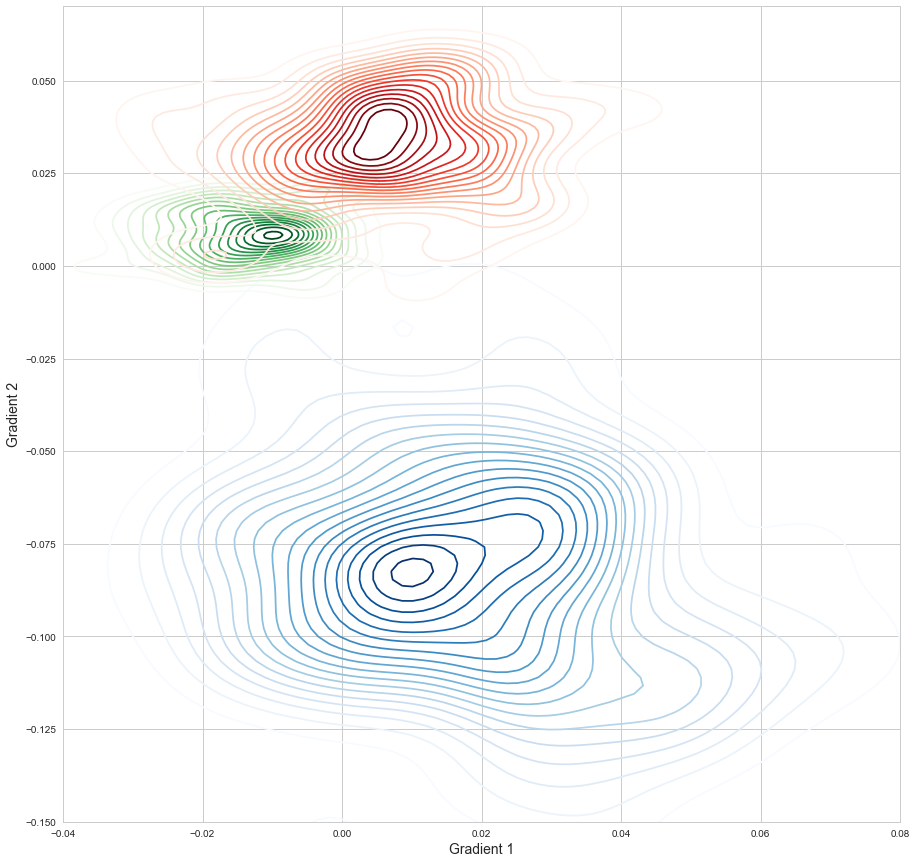

In [27]:
sns.set_style('whitegrid')

fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(111)

sns.kdeplot(f_WM_test1[range(0,300,3),0],f_WM_test1[range(0,300,3),1],
           cmap = 'Blues', label = "Fixation", shade = False, 
            shade_lowest = False, legend = True, ax = ax, n_levels = 20)

sns.kdeplot(f_WM_test1[range(1,300,3),0],f_WM_test1[range(1,300,3),1],
           cmap = 'Greens', label = "0-back", shade = False, 
            shade_lowest = False, legend = True, ax = ax, n_levels = 20)

sns.kdeplot(f_WM_test1[range(2,300,3),0],f_WM_test1[range(2,300,3),1], 
           cmap = 'Reds', label = "2-back", shade = False, 
            shade_lowest = False, legend = True, ax = ax, n_levels = 20)

ax.legend(loc = "upper left", fontsize = 14)
ax.set_xlabel("Gradient 1", fontsize = 14)
ax.set_ylabel("Gradient 2", fontsize = 14)

ax.set_xlim((-0.04,0.08))
ax.set_ylim((-0.15,0.07))

fig.savefig('../figures/KDE_G12.pdf')

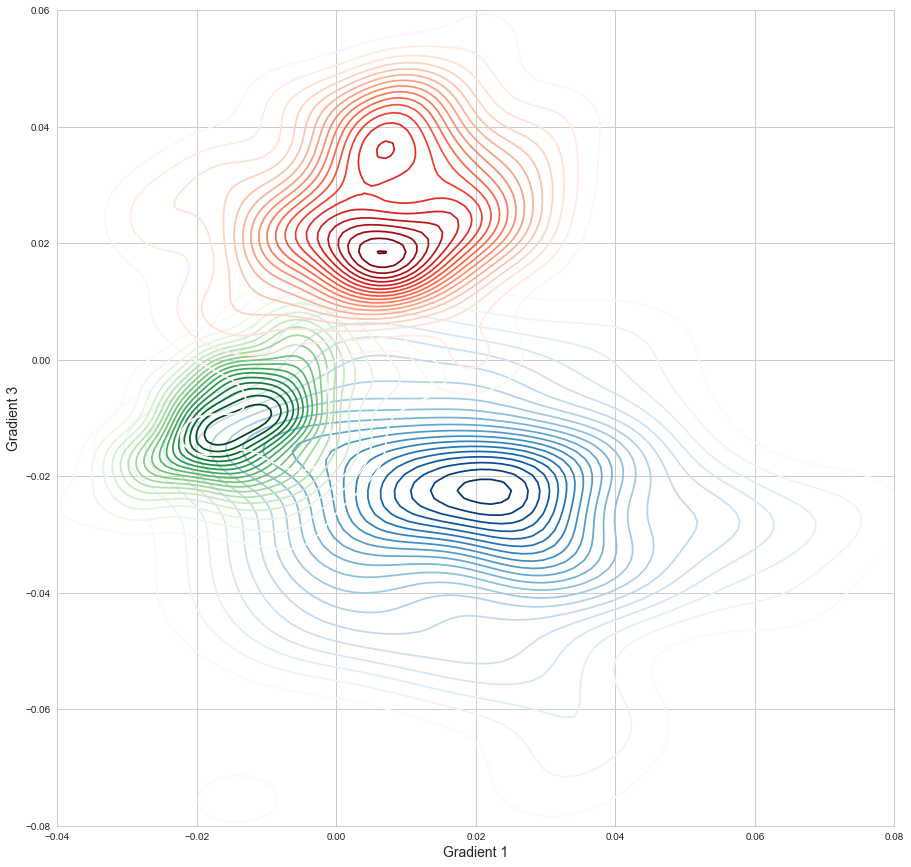

In [28]:
sns.set_style('whitegrid')

fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(111)

sns.kdeplot(f_WM_test1[range(0,300,3),0],f_WM_test1[range(0,300,3),2],
           cmap = 'Blues', label = "Fixation", shade = False, 
            shade_lowest = False, legend = True, ax = ax, n_levels = 20)

sns.kdeplot(f_WM_test1[range(1,300,3),0],f_WM_test1[range(1,300,3),2],
           cmap = 'Greens', label = "0-back", shade = False, 
            shade_lowest = False, legend = True, ax = ax, n_levels = 20)

sns.kdeplot(f_WM_test1[range(2,300,3),0],f_WM_test1[range(2,300,3),2], 
           cmap = 'Reds', label = "2-back", shade = False, 
            shade_lowest = False, legend = True, ax = ax, n_levels = 20)

ax.legend(loc = "upper left", fontsize = 14)
ax.set_xlabel("Gradient 1", fontsize = 14)
ax.set_ylabel("Gradient 3", fontsize = 14)

ax.set_xlim((-0.04,0.08))
ax.set_ylim((-0.08,0.06))

fig.savefig('../figures/KDE_G13.pdf')

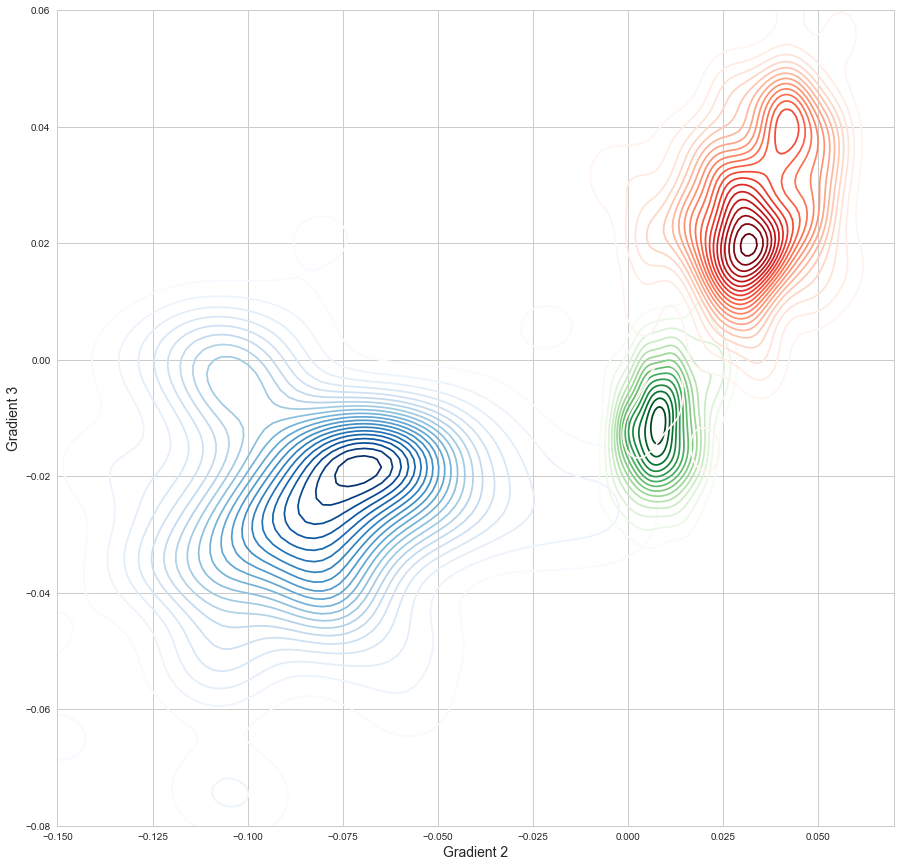

In [29]:
sns.set_style('whitegrid')

fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(111)

sns.kdeplot(f_WM_test1[range(0,300,3),1],f_WM_test1[range(0,300,3),2],
           cmap = 'Blues', label = "Fixation", shade = False, 
            shade_lowest = False, legend = True, ax = ax, n_levels = 20)

sns.kdeplot(f_WM_test1[range(1,300,3),1],f_WM_test1[range(1,300,3),2],
           cmap = 'Greens', label = "0-back", shade = False, 
            shade_lowest = False, legend = True, ax = ax, n_levels = 20)

sns.kdeplot(f_WM_test1[range(2,300,3),1],f_WM_test1[range(2,300,3),2], 
           cmap = 'Reds', label = "2-back", shade = False, 
            shade_lowest = False, legend = True, ax = ax, n_levels = 20)

ax.legend(loc = "upper left", fontsize = 14)
ax.set_xlabel("Gradient 2", fontsize = 14)
ax.set_ylabel("Gradient 3", fontsize = 14)

ax.set_xlim((-0.15,0.07))
ax.set_ylim((-0.08,0.06))

fig.savefig('../figures/KDE_G23.pdf')